# H.4] Imaginary Time Evolution
d) Numerically integrate random initial state up to certain time $\tau_{\text{max}}$

In [247]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from functools import reduce
from scipy.sparse import identity, kron, csr_matrix
from scipy.linalg import expm, eigh

In [248]:
# Set parameters
N = 4
tau_max = 25
Nsteps = 500
dt = tau_max/Nsteps

In [249]:
# Create random initial state
psi0 = np.random.randn(2**N) + 1j*np.zeros(2**N)

# Normalize
psi0 /= np.linalg.norm(psi0) 
print('Initial state |psi(0)> = ', psi0)

Initial state |psi(0)> =  [ 0.48581273+0.j -0.21001258+0.j  0.14090986+0.j  0.06022182+0.j
  0.07576869+0.j -0.20585164+0.j  0.12644419+0.j -0.02483238+0.j
  0.34006333+0.j -0.15575939+0.j -0.08920658+0.j  0.22351334+0.j
  0.17126835+0.j -0.02107431+0.j -0.41279904+0.j -0.48340229+0.j]


In [250]:
# Create Hamiltonian as matrix as done in last sheet:

# Create csr Pauli matrices
id = identity(2, format='csr')
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=np.float64)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=np.float64)

def kronecker(operators):
    # reduce calls the function (first arg) recursively on the list (second arg)
    return reduce(kron, operators)

def build_operator(operator, ind, L):
    # list of L identity operators
    operators = [id] * L

    # replace the ind-th operator with the given operator
    operators[ind] = operator

    # return the kronecker product of all identity matrices and the operator on site ind
    return csr_matrix(kronecker(operators))

def all_operators(operator):
    # a list of L operators, each one acting on a different site, otherwise identity
    return [build_operator(operator, j, N) for j in range(N)]

def Hamiltonian(h=1, J=1):
    # initialize matrices
    H = csr_matrix((2**N, 2**N), dtype=np.complex128)
    sz_list = all_operators(sigma_z)
    sx_list = all_operators(sigma_x)

    for i in range(N-1):
        H += J*(sz_list[i] @ sz_list[i+1]) + h*(sx_list[i])
    return H

In [251]:
# Define derivative using imaginary time SEQ
def dpsi_dtau(tau, psi, h=1, J=1):
    psi = psi.view(dtype=np.complex128)
    return (-Hamiltonian(h,J) @ psi).view(dtype=np.float64)

# Numerically integrate this state
sol = solve_ivp(dpsi_dtau, t_span = (0, tau_max), y0 = psi0.view(dtype=np.float64), t_eval=np.linspace(0, tau_max, Nsteps))

# Normalize wave functions of each step dt
psi_tau_list = sol.y.T.copy().view(dtype=np.complex128)   # copy to ensure that the memory is laid out contiguously before using changing the data type to complex128
psi_tau_normalized = np.array([psi / np.linalg.norm(psi) for psi in psi_tau_list])

e) Monitor convergence to ground state energy

In [252]:
# Compute energy expectation value
def E(psi, h=1, J=1):
    psi = psi.view(dtype=np.complex128)
    return np.real(np.dot(psi.conjugate().T, Hamiltonian(h, J) @ psi))      # imaginary part is of order e-17 (can be discarded)

E_tau = np.array([])
tau_list = np.linspace(0, tau_max, Nsteps)
for i in range(Nsteps):
    E_tau = np.append(E_tau, E(psi_tau_normalized[i]))

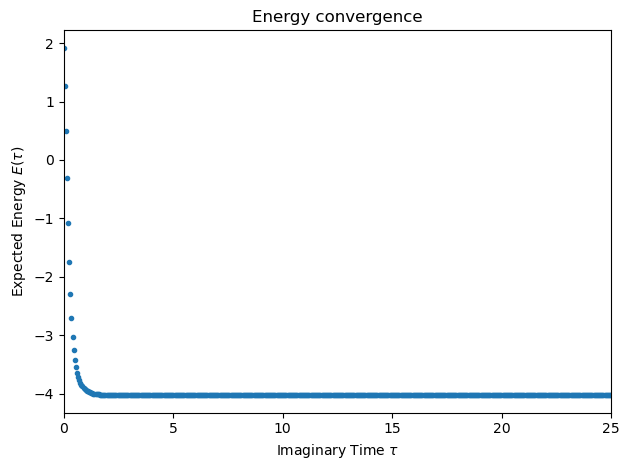

In [253]:
# Plot energy expectation value over time tau
plt.scatter(tau_list, E_tau, marker='.')

plt.xlabel(r'Imaginary Time $\tau$')
plt.ylabel(r'Expected Energy $E(\tau)$')
plt.title('Energy convergence')
plt.xlim(min(tau_list),max(tau_list))

plt.tight_layout()
plt.show()

f) Check if ITP ground state is correct

In [ ]:
ITP_groundstate = psi_tau_normalized[-1]
exact_energies, exact_eigenstates = eigh(Hamiltonian().toarray())


overlaps = np.array([])
for i in range(2):   # degenerate ground state energy -> compute overlap with both ED ground states
    overlaps = np.append(overlaps, np.real(np.dot(ITP_groundstate.conjugate().T, exact_eigenstates[:,i])))  # again, complex part close to machine precision

print("Overlap of ground state obtained with ITP and exact diagonalization: ", max(overlaps)) # overlaps vary depending on overlap of random initial state with the true ground state. maximum achieved overlap: 0.9985843368309988
print("ED ground state energy: ", exact_energies[0])

Overlap of ground state obtained with ITP and exact diagonalization:  0.9985843368309988
ED ground state energy:  -4.027339492125851


g) Compare efficiency of ITP vs real-time adiabatic evolution

The main cost occurs in the integration. Depending on the initial overlap with the true ground state, the ITP method requires less than 1000 time steps to find a wavefunction overlapping with the ground state by ~99%. The adiabatic search however, requires much more time steps in the integration.